In [1]:
! pip install --upgrade tensorflow_hub

In [2]:
! pip install tensorflow --upgrade


  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Attempting uninstall: tensorflow-io-gcs-filesystem
    Found existing installation: tensorflow-io-gcs-filesystem 0.21.0
    Uninstalling tensorflow-io-gcs-filesystem-0.21.0:
      Successfully uninstalled tensorflow-io-gcs-filesystem-0.21.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.7.0
    Uninstalling tensorboard-2.7.0:
      Successfully uninstalled tensorboard-2.7.0
  Attempting uninstall: keras
    Found existing installation: keras 2.7.0
    Uninstalling keras-2.7.0:
      Successfully uninstalled keras-2.7.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.7.0
    Uninstalling tensorflow-2.7.0:
      Successfully uninstalled tensorflow-2.7.0


In [3]:
import numpy as np 
import matplotlib.pyplot as plt
import warnings
import logging
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'



print(tf.__version__)

2.8.0


In [4]:
img_height = 224
img_width = 224
batch_size = 32
path= 'dates_dataset/dataset_combined/'

In [5]:
ds_train = tf.keras.preprocessing.image_dataset_from_directory(
    path,
    labels='inferred',    
    color_mode='rgb',
    batch_size=batch_size,
    image_size=(img_height,img_width),
    shuffle=True,
    seed=123,
    subset='training',
    validation_split=0.2
)
ds_validation = tf.keras.preprocessing.image_dataset_from_directory(
    path,
    labels='inferred',color_mode='rgb',
    batch_size=batch_size,
    image_size=(img_height,img_width),
    shuffle=True,
    seed=123,
    subset='validation',
    validation_split=0.2

)

Found 2610 files belonging to 6 classes.
Using 2088 files for training.
Found 2610 files belonging to 6 classes.
Using 522 files for validation.


## Explore Dataset 

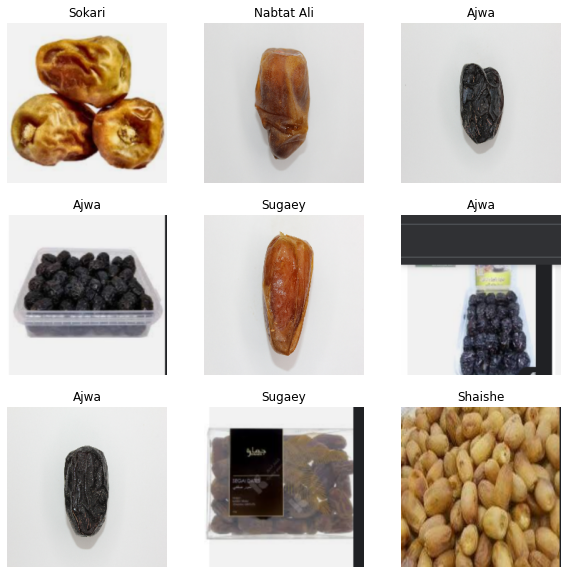

In [6]:
class_names=ds_train.class_names
plt.figure(figsize=(10, 10))
for images, labels in ds_train.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [7]:
print('Is there a GPU Available:', tf.test.is_gpu_available())


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Is there a GPU Available: True


In [8]:
def augment(image,label):
    new_height = new_width = img_height
    image = tf.image.resize(image, (new_height, new_width))

    if tf.random.uniform((), minval=0, maxval=1) < 0.1:
        image = tf.tile(tf.image.rgb_to_grayscale(image), [1, 1, 3])

    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.1, upper=0.2)

    image = tf.image.random_flip_left_right(image)  # 50%

    return image, label

## Model Building

Here I am building the model layers useing Tensorflow Functional API

In [9]:
num_classes = 6
model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

# Using Transfer Model
# mobilenet_v2 ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4"

# model = tf.keras.Sequential([
#     hub.KerasLayer(mobilenet_v2,input_shape=(img_height, img_width, 3),
#                    trainable=False),  # Can be True, see below.
#     tf.keras.layers.Dense(num_classes, activation='softmax')
# ])
# model.summary()

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 64)        1

In [11]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 64)        1

In [12]:
epochs=5
history = model.fit_generator(
  ds_train,
  validation_data=ds_validation,
  epochs=epochs
)

C:\Users\Saleh\AppData\Local\Temp/ipykernel_27144/71900884.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/5
66/66 [==============================] - 94s 1s/step - loss: 1.7718 - accuracy: 0.3137 - val_loss: 1.3446 - val_accuracy: 0.3946
Epoch 2/5
66/66 [==============================] - 133s 2s/step - loss: 1.2812 - accuracy: 0.4823 - val_loss: 1.1930 - val_accuracy: 0.5172
Epoch 3/5
66/66 [==============================] - 76s 1s/step - loss: 1.0541 - accuracy: 0.6111 - val_loss: 1.1432 - val_accuracy: 0.5249
Epoch 4/5
66/66 [==============================] - 75s 994ms/step - loss: 0.8561 - accuracy: 0.6925 - val_loss: 1.1761 - val_accuracy: 0.5958
Epoch 5/5
66/66 [==============================] - 66s 918ms/step - loss: 0.6508 - accuracy: 0.7605 - val_loss: 1.1809 - val_accuracy: 0.6360


In [13]:
def model_val_score(result):
    acc = result.history['accuracy']
    val_acc = result.history['val_accuracy']

    loss = result.history['loss']
    val_loss = result.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

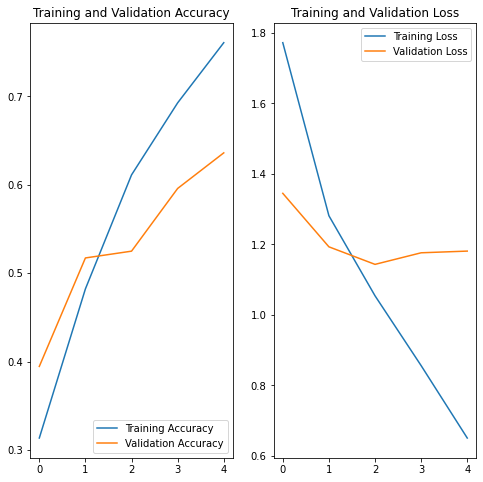

In [14]:
model_val_score(history)

In [15]:
def predict(img_path,top_k):
    img = tf.keras.utils.load_img(img_path,target_size=(img_height, img_width))
    img_path, target_size=(img_height, img_width)
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    probs = model.predict(img_array)
    probs = probs[0].tolist()
    prob,i = tf.math.top_k(probs,k=top_k)
    probs = prob.numpy().tolist()
    classes=i.numpy().tolist()
    return probs,classes

def plot_image_prediction(image_path,top_K=5):
    # open image 
    opened_image=Image.open(image_path)
    # predict image
    probs,classes = predict(image_path,top_K)
    classNames=[]
    for i in range(top_K):
        classNames.append(class_names[(classes[i])])
        percentage = "{:.2%}".format(probs[i])
        print(classNames[i],' : ',percentage)
    # plot results 
    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(opened_image, cmap = plt.cm.binary)
    ax1.axis('off')
    ax1.set_title(classNames[0],fontdict={'color': 'white',})
    ax2.barh(np.arange(top_K), probs)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(top_K))
    ax2.set_yticklabels(classNames)
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()

In [16]:
class_names[1]

'Medjool'

Ajwa  :  1002.81%
Medjool  :  472.46%
Medjool  :  268.82%
Shaishe  :  182.47%
Sokari  :  433.23%
Shaishe  :  302.59%
Medjool  :  424.58%
Shaishe  :  272.85%


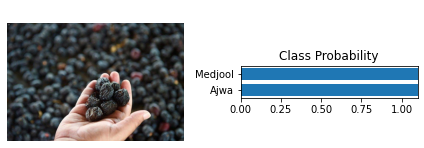

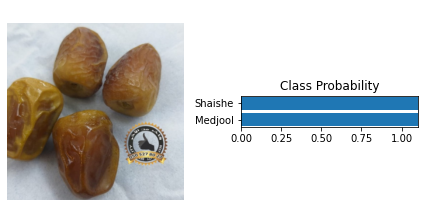

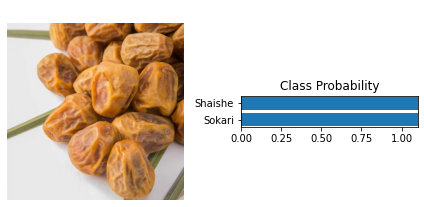

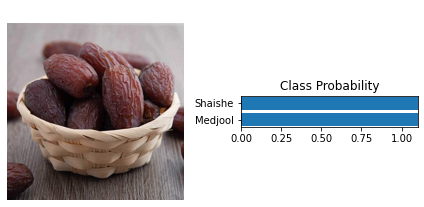

In [17]:
# Testing Images outside
images = [
'ajwa01out.jpeg','sokari-3-p.jpg','Sukkari-Fakher-500.jpg','mjdool.jpg'
]
for image in images:
    image_parent_path = './dates_dataset/dates_outside/'
    image_path = image_parent_path+image
    plot_image_prediction(image_path,top_K=2)

In [18]:
# loss, accuracy= model.evaluate(testing_batches)

# print('\n\tLoss ont test is : {:,.3f} '.format(loss))
# print('\n\tAccuracy ont test is : {:.3%}'.format(accuracy))

## Export Model 

In [25]:
import time

t = time.time()

saved_keras_model_filepath = './models/{}'.format(int(t))

# model.save(saved_keras_model_filepath)
tf.saved_model.save(model,saved_keras_model_filepath)

INFO:tensorflow:Assets written to: ./models/1644671406\assets


In [26]:
# Convert the model
saved_model_dir =  saved_keras_model_filepath
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir) # path to the SavedModel directory
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)